# Giảm chiều dữ liệu (full script)
#### <span style="color: gold;"> Thầy/cô chỉ cần chạy 2 cells dưới cho PCA và LDA</span>


Kết luận : LDA chỉ cần đến 2 thành phần đầu tiên đã nắm được ~ 97% thông tin, vượt trội hơn hẳn so với PCA (6 thành phần ~84%).

9 classes: Lấy 6 chiều còn ~ 84.26% thông tin
4 classes: Lấy 6 chiều còn ~ 84.28% thông tin


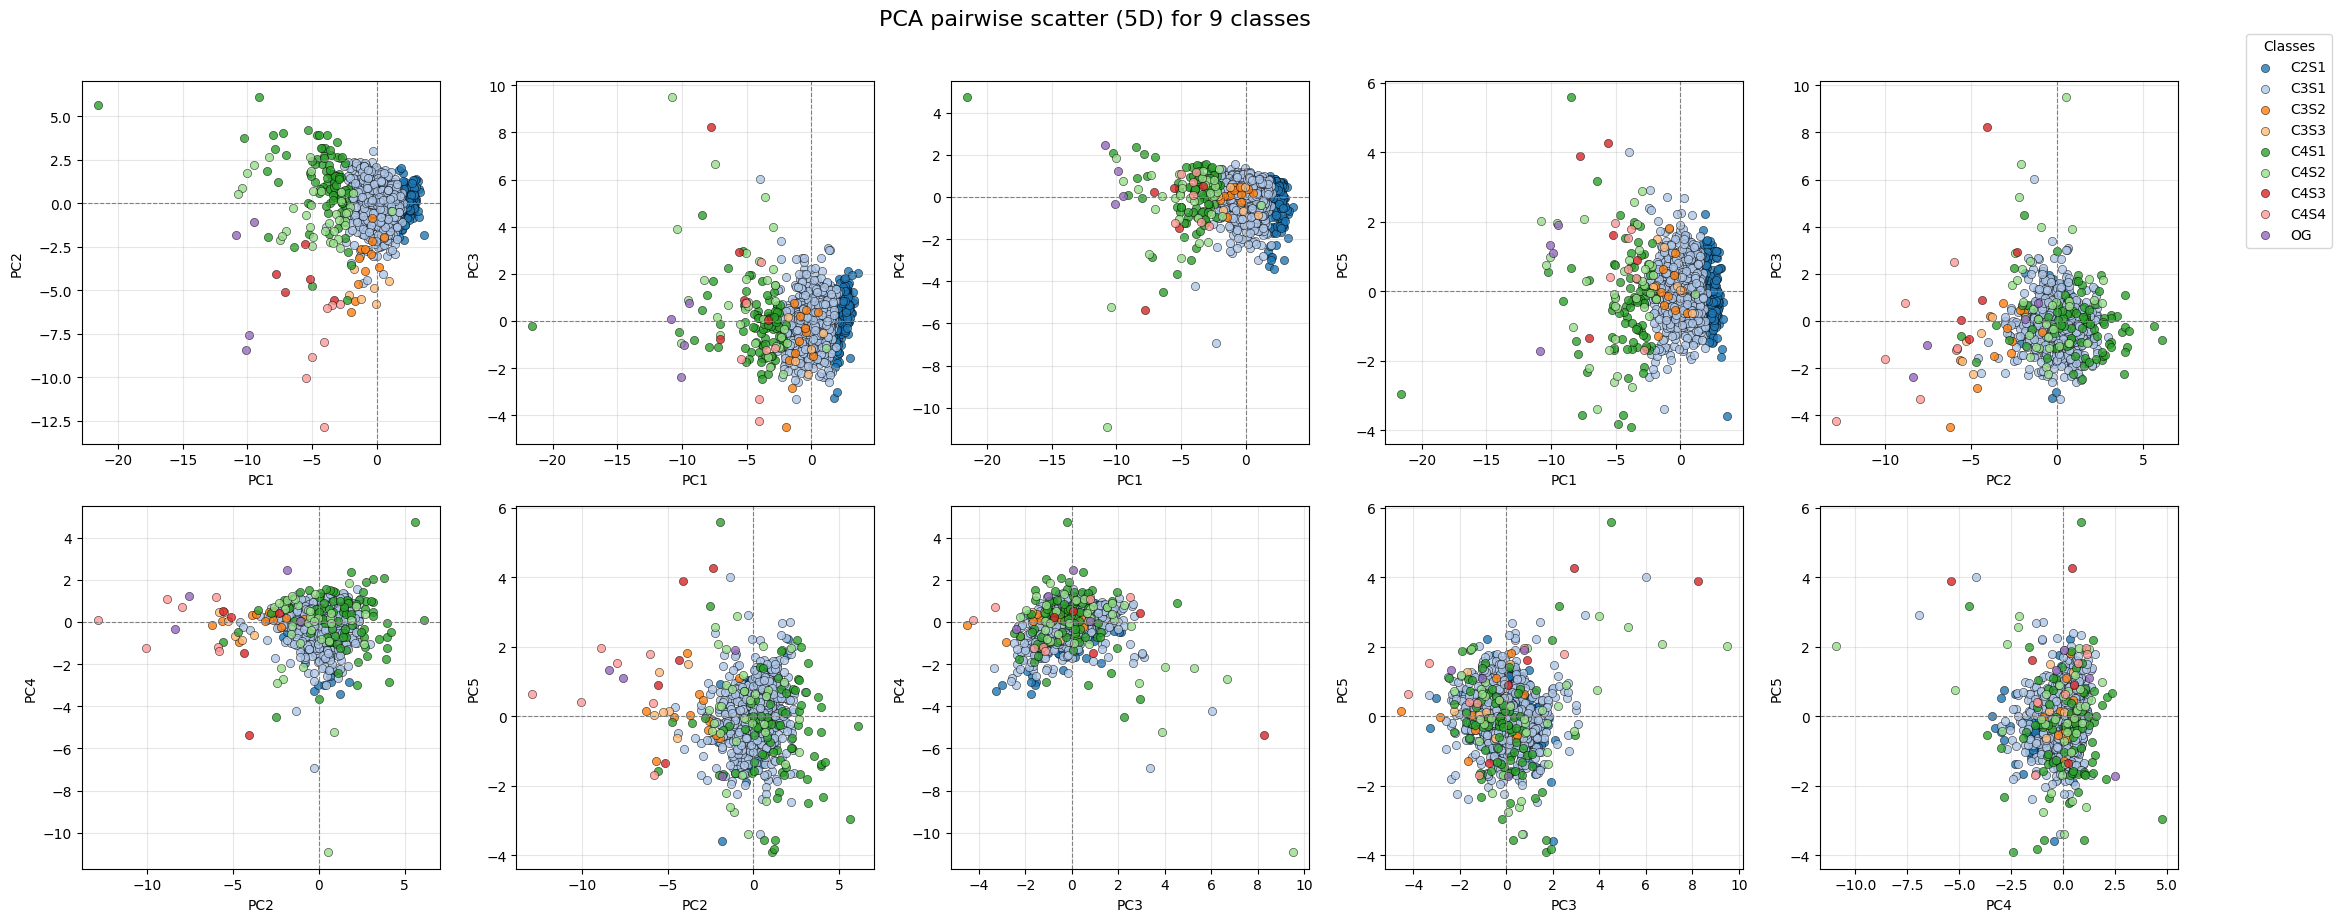

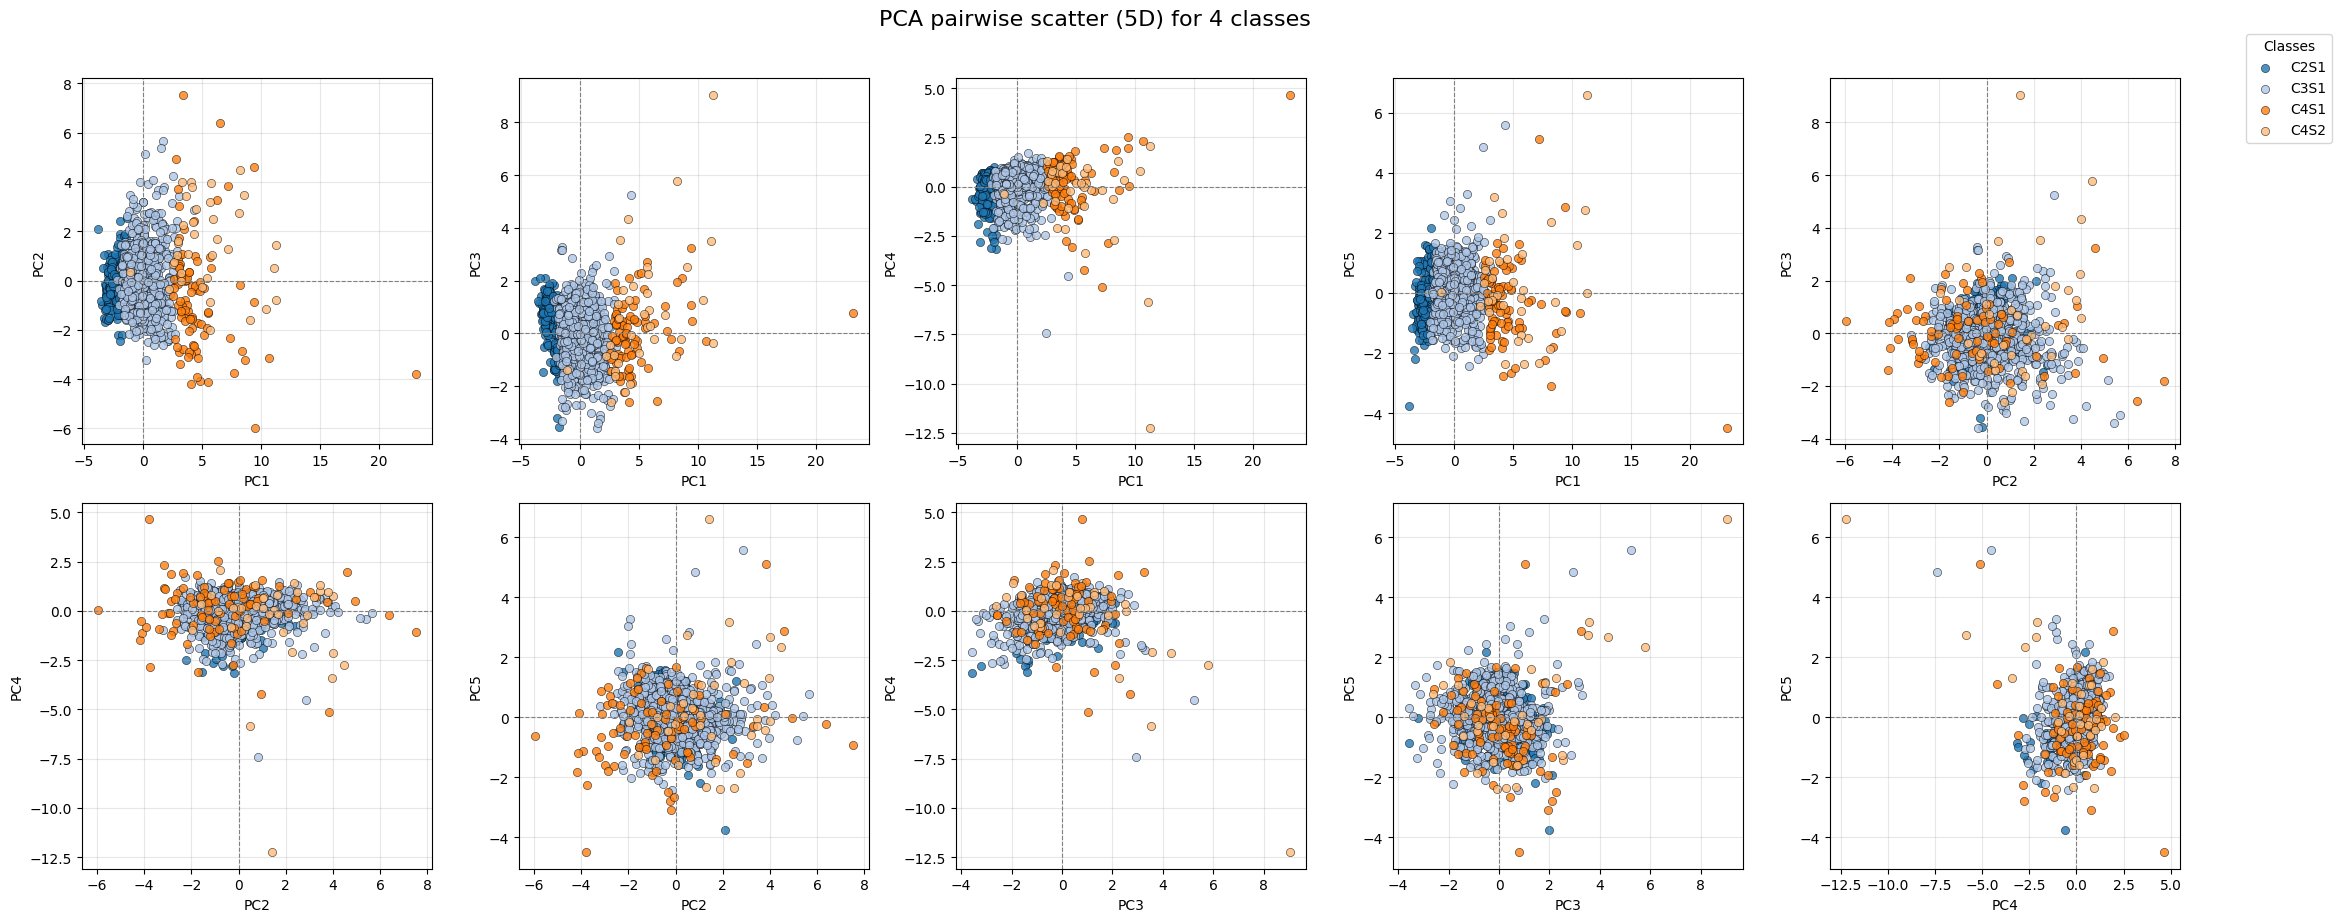

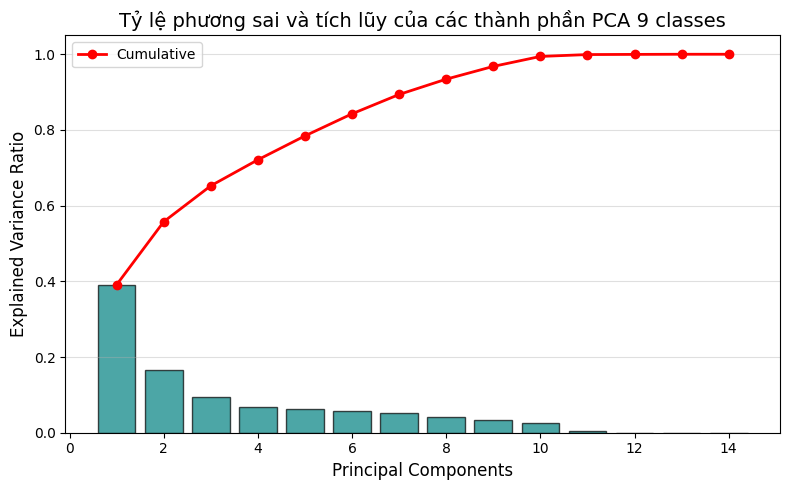

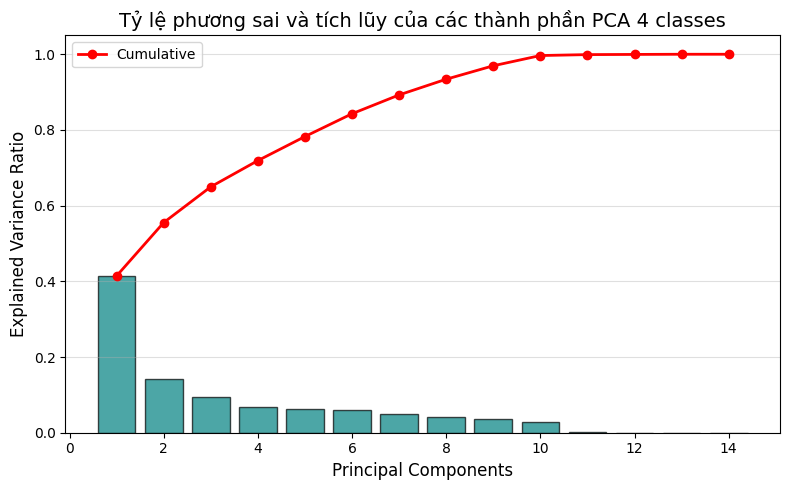

In [ ]:
# PCA và lưu dữ liệu sau giảm chiều vào X_4/9_classes_PCA_6dims.csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
import os

BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

data_path_9_classes = os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv')
data_path_4_classes = os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv')

X_9_classes = pd.read_csv(data_path_9_classes).drop(columns=['Classification'])
y_9_classes = pd.read_csv(data_path_9_classes)['Classification']
X_4_classes = pd.read_csv(data_path_4_classes).drop(columns=['Classification'])
y_4_classes = pd.read_csv(data_path_4_classes)['Classification']

def PCA_reduce(X, k):
  #Scaler
  X_num = X.select_dtypes(include=['float64', 'int64'])

  # NaN handle (sửa lại hàm này sau)
  X_num = X_num.fillna(X_num.mean())
  X_scaled = (X_num - X_num.mean()) / X_num.std(ddof=0)

  #Tính ma trận hiệp phương sai
  X_corr = (1 / (len(X_scaled))) * X_scaled.T.dot(X_scaled)

  #Tính gtr, vtr
  eig_vals, eig_vecs = np.linalg.eig(X_corr)

  # Sort lại các giá trị riêng giảm dần, theo index
  idx = np.argsort(eig_vals)[::-1]

  # Lấy gtr, vtr theo index đã sort
  eig_vals = eig_vals[idx]
  eig_vecs = eig_vecs[:, idx]

  # Tính tỷ lệ phương sai
  var_ratio = eig_vals / np.sum(eig_vals)

  #Lấy k chiều (chiếu lên)
  W = eig_vecs[:, :k]
  X_pca = X_scaled @ W
  return X_pca, eig_vals, eig_vecs, X_scaled

X_9_pca, eig_9_vals, eig_9_vecs, X_9_scaled = PCA_reduce(X_9_classes, 10)
X_4_pca, eig_4_vals, eig_4_vecs, X_4_scaled = PCA_reduce(X_4_classes, 10)

# gtr có thể phức nên lấy real cho chắc
eig_9_vals = np.real(eig_9_vals)

# dùng phương sai giải thích
var_9_ratio = eig_9_vals / eig_9_vals.sum()
info_2d = var_9_ratio[:6].sum()
print(f"9 classes: Lấy 6 chiều còn ~ {info_2d*100:.2f}% thông tin")

# gtr có thể phức nên lấy real cho chắc
eig_4_vals = np.real(eig_4_vals)

# dùng phương sai giải thích
var_4_ratio = eig_4_vals / eig_4_vals.sum()
info_2d = var_4_ratio[:6].sum()
print(f"4 classes: Lấy 6 chiều còn ~ {info_2d*100:.2f}% thông tin")

def plot_pca_5d_stylish(X_pca_5: pd.DataFrame, y, class_labels):
    """
    Vẽ 10 subplot (2x5) cho 5 thành phần PCA (PC1..PC5)

    X_pca_5 : DataFrame có >=5 cột PCA
    y : mảng nhãn số hóa (0..C-1)
    class_labels : danh sách tên lớp tương ứng
    title : tiêu đề chính
    """
    title=f"PCA pairwise scatter (5D) for {len(class_labels)} classes"
    # Kiểm tra
    if X_pca_5.shape[1] < 5:
        raise ValueError("Cần ít nhất 5 thành phần PCA (PC1..PC5).")

    pcs = [f"PC{i+1}" for i in range(5)]
    pairs = list(itertools.combinations(range(5), 2))  # (0,1), (0,2), ...
    cmap = sns.color_palette("tab20", len(np.unique(y)))

    # Tạo figure 2 hàng, 5 cột
    fig, axes = plt.subplots(2, 5, figsize=(22, 9))
    fig.suptitle(title, fontsize=16, y=1.02)

    y = np.asarray(y)
    for idx, (i, j) in enumerate(pairs):
        ax = axes[idx // 5, idx % 5]
        for c in np.unique(y):
            idxs = (y == c)
            ax.scatter(
                X_pca_5.iloc[idxs, i],
                X_pca_5.iloc[idxs, j],
                color=cmap[c],
                s=35,
                alpha=0.8,
                edgecolor='k',
                linewidth=0.4,
                label=class_labels[c] if idx == 0 else None  # chỉ add legend 1 lần
            )

        ax.axhline(0, color='gray', lw=0.8, ls='--')
        ax.axvline(0, color='gray', lw=0.8, ls='--')
        ax.set_xlabel(pcs[i], fontsize=10)
        ax.set_ylabel(pcs[j], fontsize=10)
        ax.grid(alpha=0.3)

    # Legend chung (ngoài cùng)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

classes, y_enc = np.unique(y_9_classes, return_inverse=True)
plot_pca_5d_stylish(X_9_pca, y_enc, classes)
classes, y_enc = np.unique(y_4_classes, return_inverse=True)
plot_pca_5d_stylish(X_4_pca, y_enc, classes)

def plot_pca_variance(var_ratio, n_classes):
    cum_var = np.cumsum(var_ratio)

    plt.figure(figsize=(8,5))

    # Vẽ bar
    plt.bar(
        range(1, len(var_ratio)+1),
        var_ratio,
        alpha=0.7,
        color='teal',
        edgecolor='black',
    )

    # Vẽ đường cộng dồn
    plt.plot(
        range(1, len(cum_var)+1),
        cum_var,
        marker='o',
        color='red',
        linewidth=2,
        label='Cumulative'
    )

    plt.xlabel('Principal Components', fontsize=12)
    plt.ylabel('Explained Variance Ratio', fontsize=12)
    plt.title(f'Tỷ lệ phương sai và tích lũy của các thành phần PCA {n_classes} classes', fontsize=14)
    plt.grid(axis='y', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_variance(var_9_ratio, 9)
plot_pca_variance(var_4_ratio, 4)

df_pca_4_classes_6_dim = pd.concat([X_4_pca, y_4_classes.reset_index(drop=True)], axis=1)
df_pca_4_classes_6_dim = df_pca_4_classes_6_dim.rename(columns={df_pca_4_classes_6_dim.columns[-1]: 'Classification'})
df_pca_4_classes_6_dim = pd.concat([df_pca_4_classes_6_dim.iloc[:, :6], df_pca_4_classes_6_dim['Classification']], axis=1)
df_pca_4_classes_6_dim.to_csv(os.path.join(BASE_DIR, 'data/X_4_classes_PCA_6dims.csv'), index=False)

df_pca_9_classes_6_dim = pd.concat([X_9_pca, y_9_classes.reset_index(drop=True)], axis=1)
df_pca_9_classes_6_dim = df_pca_9_classes_6_dim.rename(columns={df_pca_9_classes_6_dim.columns[-1]: 'Classification'})
df_pca_9_classes_6_dim = pd.concat([df_pca_9_classes_6_dim.iloc[:, :6], df_pca_9_classes_6_dim['Classification']], axis=1)
df_pca_9_classes_6_dim.to_csv(os.path.join(BASE_DIR, 'data/X_9_classes_PCA_6dims.csv'), index=False)

Lấy 2 chiều còn ~ 97.76% thông tin (LDA) cho 4 classes
Lấy 2 chiều còn ~ 96.88% thông tin (LDA) cho 9 classes


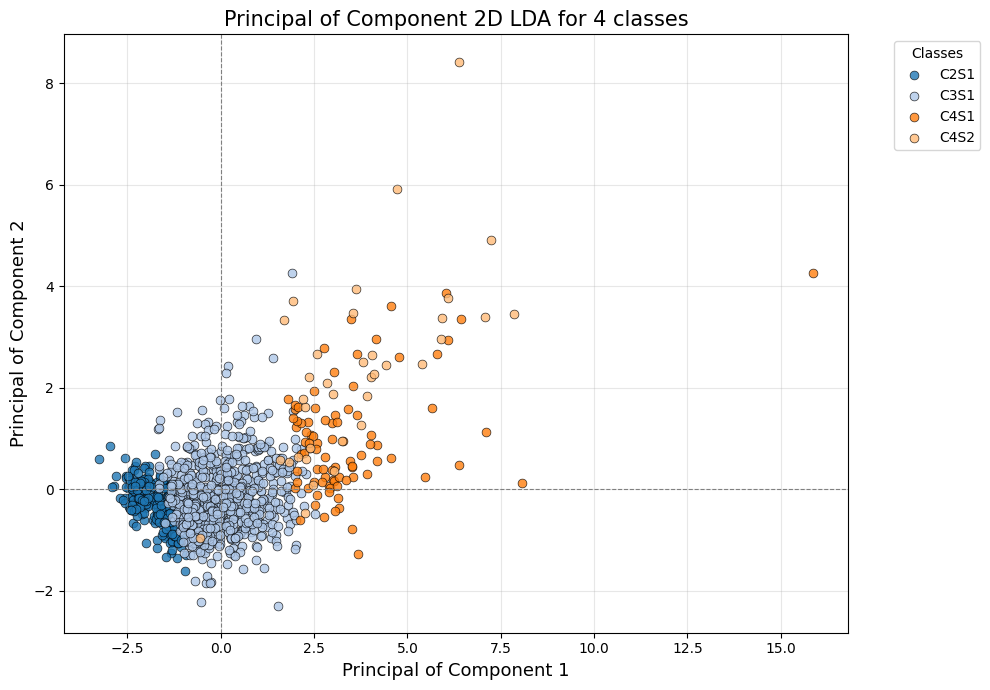

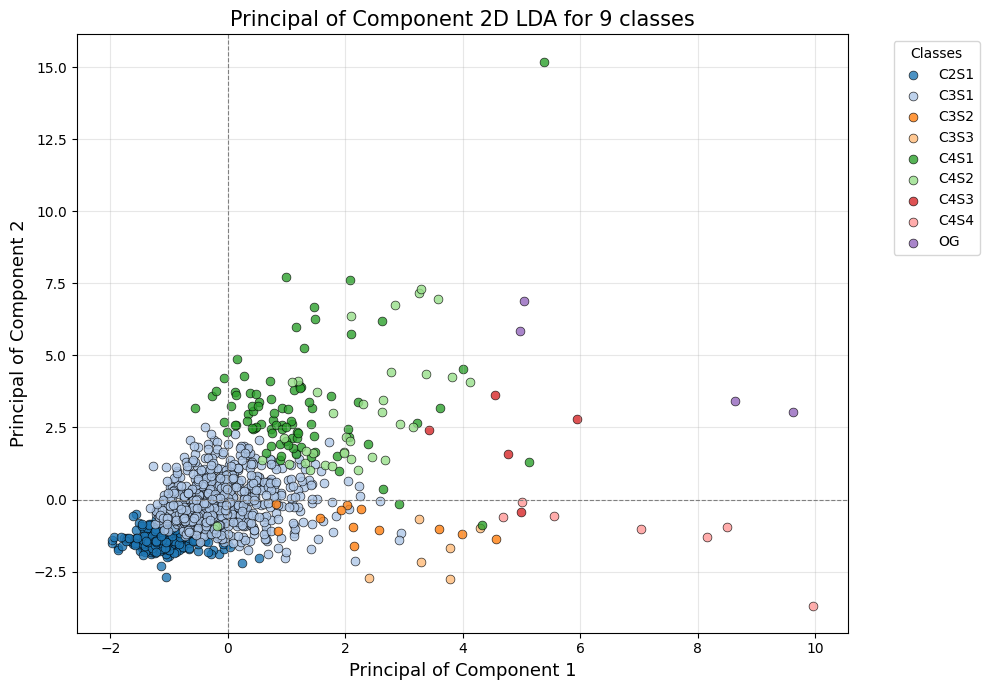

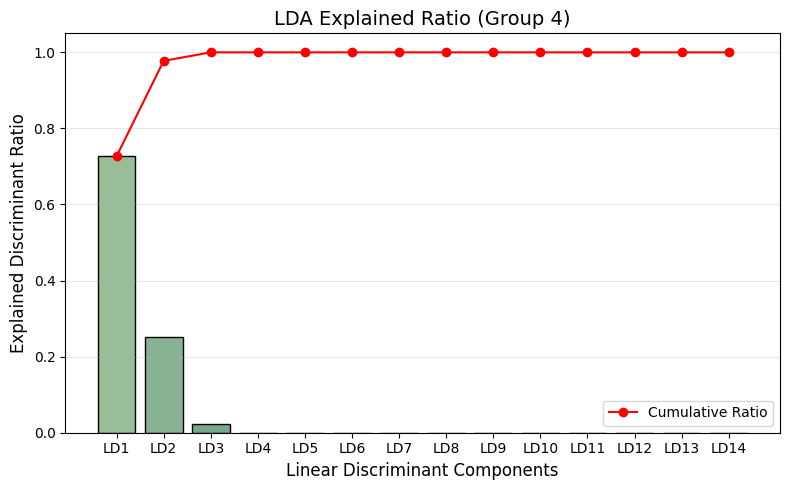

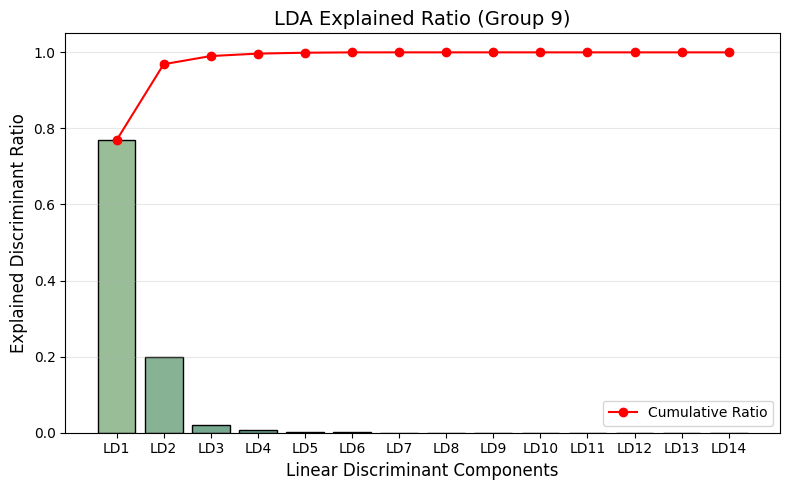

In [2]:
# LDA và lưu dữ liệu sau giảm chiều vào X_4/9_classes_LDA_2dims.csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
import os

BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

data_path_9_classes = os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv')
data_path_4_classes = os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv')

X_9_classes = pd.read_csv(data_path_9_classes).drop(columns=['Classification'])
y_9_classes = pd.read_csv(data_path_9_classes)['Classification']
X_4_classes = pd.read_csv(data_path_4_classes).drop(columns=['Classification'])
y_4_classes = pd.read_csv(data_path_4_classes)['Classification']

def LDA_reduce(X, species, k):
  #Scaler
  X_num = X.select_dtypes(include=['float64', 'int64']).copy()

  #NaN handling (sửa lại hàm này sau)
  X_num = X_num.fillna(X_num.mean())

  X_scaled = (X_num - X_num.mean()) / X_num.std(ddof=0)
  X = X_scaled.to_numpy() # dim: (n, d)

  #encode species
  y = species.to_numpy()
  classes, y_enc = np.unique(y, return_inverse=True)

  n, d = X.shape
  C = len(classes)

  # Tính mean toàn cục
  m = X.mean(axis=0, keepdims=True).T #dim: (d, 1)

  # Tính Sw và Sb
  S_W = np.zeros((d, d), dtype=float)
  S_B = np.zeros((d, d), dtype=float)

  for c in range(C):
    Xc = X[y_enc == c]# dim: (n_c, d)
    n_c = Xc.shape[0]
    if n_c == 0:
        continue

    mc = Xc.mean(axis=0, keepdims=True).T
    #Sw
    XcT = Xc.T
    SWc = (XcT - mc @ np.ones((1, n_c))) @ (XcT - mc @ np.ones((1, n_c))).T
    S_W += SWc

    #Sb
    a = (mc - m)#(d,1)
    S_B += n_c * (a @ a.T)

  # Thêm reg để tránh singular
  reg = 1e-3
  S_W_reg = S_W + reg * np.eye(d)

  M = np.linalg.pinv(S_W_reg) @ S_B
  # Ép đối xứng để gtr riêng thực
  M = 0.5 * (M + M.T)

  # Phân rã gtr, vtr
  L, W = np.linalg.eigh(M)
  # Sắp xếp giảm dần, lấy theo index
  idx = np.argsort(L)[::-1]

  # Lấy gtr, vtr theo index đã sort
  L = L[idx]
  W = W[:, idx]

  # Lấy k thành phần
  Wk = W[:, :k] # dim: (d, k)

  # Chiếu dữ liệu: Z = XW
  Xc = X - X.mean(axis=0, keepdims=True)
  Z = Xc @ Wk # dim: (n, k)

  return Z, L, W, Xc

Z_4, L_4, W_4, Xc_4 = LDA_reduce(X_4_classes, y_4_classes, 2)
Z_9, L_9, W_9, Xc_9 = LDA_reduce(X_9_classes, y_9_classes, 2)

def get_var_ratio_lda(L):
    L = np.real(L)

    # Loại bỏ gtr âm
    L = np.where(L > 0, L, 0.0)
    den = L.sum()
    if den > 0:
        return L / den
    else:
        return np.zeros_like(L)
    
var_4_ratio = get_var_ratio_lda(L_4)
info_2d = var_4_ratio[:2].sum()
print(f"Lấy 2 chiều còn ~ {info_2d*100:.2f}% thông tin (LDA) cho 4 classes")
var_9_ratio = get_var_ratio_lda(L_9)
info_2d = var_9_ratio[:2].sum()
print(f"Lấy 2 chiều còn ~ {info_2d*100:.2f}% thông tin (LDA) cho 9 classes")

def plot_lda_2d(Z, y, class_labels, title='LDA 2D projection'):
    """
    Z: ma trận sau giảm chiều (n, 2)
    y: nhãn đã mã hoá số nguyên (0..C-1)
    class_labels: danh sách tên lớp gốc (để legend)
    """
    plt.figure(figsize=(10, 7))
    y = np.asarray(y)
    classes = np.unique(y)

    palette = sns.color_palette("tab20", len(classes))
    for i, c in enumerate(classes):
        idx = (y == c)
        plt.scatter(
            Z[idx, 0], Z[idx, 1],
            label=class_labels[i],
            color=palette[i],
            s=40, alpha=0.8, edgecolor='k', linewidth=0.5
        )

    plt.axhline(0, color='gray', lw=0.8, ls='--')
    plt.axvline(0, color='gray', lw=0.8, ls='--')
    plt.title(title, fontsize=15)
    plt.xlabel("Principal of Component 1", fontsize=13)
    plt.ylabel("Principal of Component 2", fontsize=13)
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

classes, y_enc = np.unique(y_4_classes, return_inverse=True)
plot_lda_2d(Z_4, y_enc, classes, title='Principal of Component 2D LDA for 4 classes')
classes, y_enc = np.unique(y_9_classes, return_inverse=True)
plot_lda_2d(Z_9, y_enc, classes, title='Principal of Component 2D LDA for 9 classes')

def plot_lda_bar(L, title="LDA Discriminant Power (Explained Ratio)"):
    # Lấy phần thực và bỏ trị riêng âm
    L = np.real(L)
    L = np.clip(L, 0, None)  # nếu có âm → 0

    # Tính tỷ lệ phần trăm
    total = L.sum()
    var_ratio = L / total if total > 0 else np.zeros_like(L)
    cum_ratio = np.cumsum(var_ratio)

    # Bar + Cumulative Ratio
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        x=[f"LD{i+1}" for i in range(len(L))],
        y=var_ratio,
        hue=[f"LD{i+1}" for i in range(len(L))],
        palette="crest",
        edgecolor="black",
        dodge=False
    )
    # remove legend (since hue was used to map palette)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    plt.plot(
        range(len(L)), cum_ratio,
        color="red", marker="o", linewidth=1.5,
        label="Cumulative Ratio"
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Linear Discriminant Components", fontsize=12)
    plt.ylabel("Explained Discriminant Ratio", fontsize=12)
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_lda_bar(L_4, title="LDA Explained Ratio (Group 4)")
plot_lda_bar(L_9, title="LDA Explained Ratio (Group 9)")

# Convert numpy arrays to DataFrames before concatenating
df_lda_4_classes_2_dim = pd.DataFrame(Z_4, columns=['LD1', 'LD2'])
df_lda_4_classes_2_dim['Classification'] = y_4_classes.reset_index(drop=True)
df_lda_4_classes_2_dim.to_csv(os.path.join(BASE_DIR, 'data/X_4_classes_LDA_2dims.csv'), index=False)

df_lda_9_classes_2_dim = pd.DataFrame(Z_9, columns=['LD1', 'LD2'])
df_lda_9_classes_2_dim['Classification'] = y_9_classes.reset_index(drop=True)
df_lda_9_classes_2_dim.to_csv(os.path.join(BASE_DIR, 'data/X_9_classes_LDA_2dims.csv'), index=False)


# Các thử nghiệm

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

data_path_9_classes = os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv')
data_path_4_classes = os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv')

In [16]:
X_9_classes = pd.read_csv(data_path_9_classes).drop(columns=['Classification'])
y_9_classes = pd.read_csv(data_path_9_classes)['Classification']
X_4_classes = pd.read_csv(data_path_4_classes).drop(columns=['Classification'])
y_4_classes = pd.read_csv(data_path_4_classes)['Classification']

In [11]:
def PCA_reduce(X, k):
  #Scaler
  X_num = X.select_dtypes(include=['float64', 'int64'])

  # NaN handle (sửa lại hàm này sau)
  X_num = X_num.fillna(X_num.mean())
  X_scaled = (X_num - X_num.mean()) / X_num.std(ddof=0)

  #Tính ma trận hiệp phương sai
  X_corr = (1 / (len(X_scaled))) * X_scaled.T.dot(X_scaled)

  #Tính gtr, vtr
  eig_vals, eig_vecs = np.linalg.eig(X_corr)

  # Sort lại các giá trị riêng giảm dần, theo index
  idx = np.argsort(eig_vals)[::-1]

  # Lấy gtr, vtr theo index đã sort
  eig_vals = eig_vals[idx]
  eig_vecs = eig_vecs[:, idx]

  # Tính tỷ lệ phương sai
  var_ratio = eig_vals / np.sum(eig_vals)

  #Lấy k chiều (chiếu lên)
  W = eig_vecs[:, :k]
  X_pca = X_scaled @ W
  return X_pca, eig_vals, eig_vecs, X_scaled

In [17]:
X_9_pca, eig_9_vals, eig_9_vecs, X_9_scaled = PCA_reduce(X_9_classes, 10)

In [14]:
# gtr có thể phức nên lấy real cho chắc
eig_9_vals = np.real(eig_9_vals)

# dùng phương sai giải thích
var_9_ratio = eig_9_vals / eig_9_vals.sum()
info_2d = var_9_ratio[:6].sum()
print(f"Lấy 6 chiều còn ~ {info_2d*100:.2f}% thông tin")

Lấy 6 chiều còn ~ 84.26% thông tin


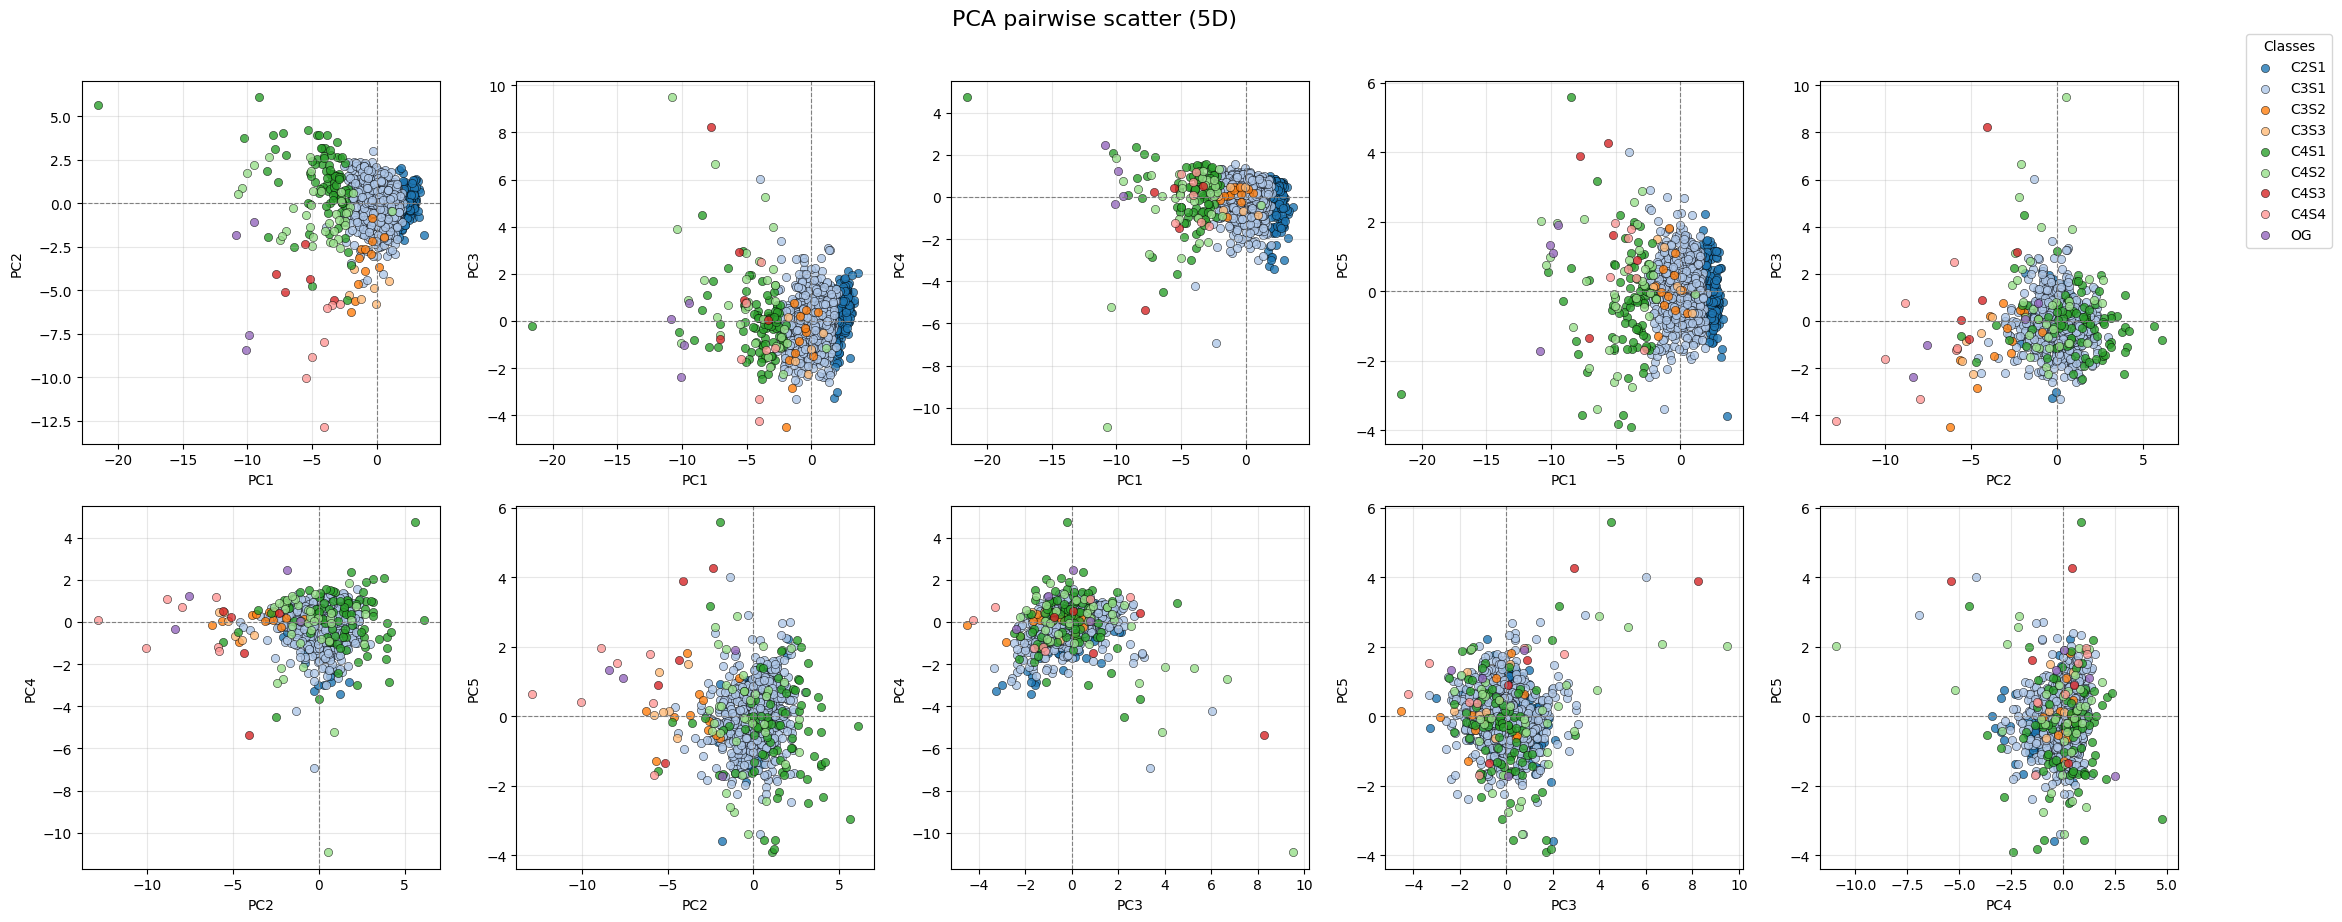

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import pandas as pd

def plot_pca_5d_stylish(X_pca_5: pd.DataFrame, y, class_labels, title="PCA pairwise scatter (5D)"):
    """
    Vẽ 10 subplot (2x5) cho 5 thành phần PCA (PC1..PC5)

    X_pca_5 : DataFrame có >=5 cột PCA
    y : mảng nhãn số hóa (0..C-1)
    class_labels : danh sách tên lớp tương ứng
    title : tiêu đề chính
    """
    # Kiểm tra
    if X_pca_5.shape[1] < 5:
        raise ValueError("Cần ít nhất 5 thành phần PCA (PC1..PC5).")

    pcs = [f"PC{i+1}" for i in range(5)]
    pairs = list(itertools.combinations(range(5), 2))  # (0,1), (0,2), ...
    cmap = sns.color_palette("tab20", len(np.unique(y)))

    # Tạo figure 2 hàng, 5 cột
    fig, axes = plt.subplots(2, 5, figsize=(22, 9))
    fig.suptitle(title, fontsize=16, y=1.02)

    y = np.asarray(y)
    for idx, (i, j) in enumerate(pairs):
        ax = axes[idx // 5, idx % 5]
        for c in np.unique(y):
            idxs = (y == c)
            ax.scatter(
                X_pca_5.iloc[idxs, i],
                X_pca_5.iloc[idxs, j],
                color=cmap[c],
                s=35,
                alpha=0.8,
                edgecolor='k',
                linewidth=0.4,
                label=class_labels[c] if idx == 0 else None  # chỉ add legend 1 lần
            )

        ax.axhline(0, color='gray', lw=0.8, ls='--')
        ax.axvline(0, color='gray', lw=0.8, ls='--')
        ax.set_xlabel(pcs[i], fontsize=10)
        ax.set_ylabel(pcs[j], fontsize=10)
        ax.grid(alpha=0.3)

    # Legend chung (ngoài cùng)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

classes, y_enc = np.unique(y_9_classes, return_inverse=True)
plot_pca_5d_stylish(X_9_pca, y_enc, classes)


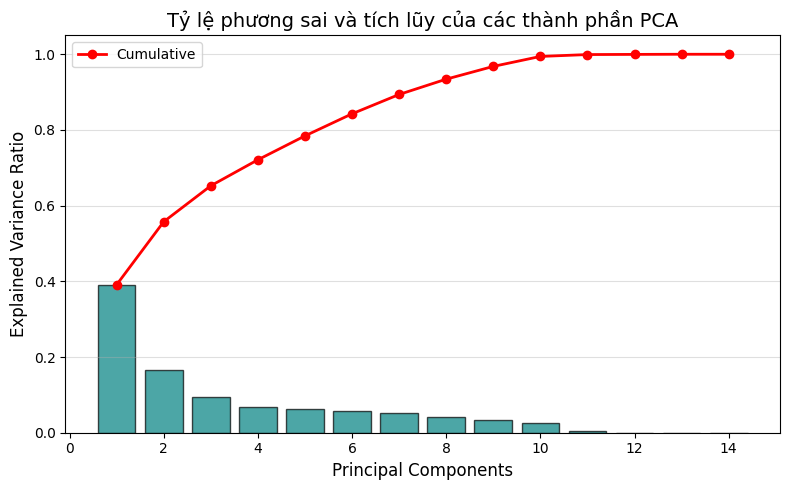

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ví dụ giả định:
# var_4_ratio = np.array([0.42, 0.27, 0.18, 0.09, 0.04])
cum_var = np.cumsum(var_9_ratio)

plt.figure(figsize=(8,5))

# Vẽ bar
plt.bar(
    range(1, len(var_9_ratio)+1),
    var_9_ratio,
    alpha=0.7,
    color='teal',
    edgecolor='black',
)

# Vẽ đường cộng dồn
plt.plot(
    range(1, len(cum_var)+1),
    cum_var,
    marker='o',
    color='red',
    linewidth=2,
    label='Cumulative'
)

plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Tỷ lệ phương sai và tích lũy của các thành phần PCA', fontsize=14)
plt.grid(axis='y', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
